In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from astropy.io import fits
from astropy.table import Table

In [2]:
ROOT = "/home/denis/.birales/visualisation/fits/30774"
OUT_DIR = "/home/denis/.birales/visualisation/analysis"
hdu_list = fits.open(ROOT+"/30774_raw.fits")

In [7]:
SAVE_FIGURES = True
UNI_RED = '#BA0C2F'
CMAP = sns.dark_palette('#BA0C2F', as_cmap=True)

In [4]:
# Seaborn settings
# This sets reasonable defaults for font size for
# a figure that will go in a paper
sns.set_context("poster")

# Set the font to be serif, rather than sans
sns.set(font='serif')

# Make the background white, and specify the
# specific font family
sns.set_style("ticks",
              {'axes.axisbelow': True,
                 'axes.edgecolor': '#666666',
                 'axes.facecolor': 'white',
                 'axes.grid': True,
                 'axes.labelcolor': '.15',
                 'axes.spines.bottom': True,
                 'axes.spines.left': True,
                 'axes.spines.right': True,
                 'axes.spines.top': True,
                 'figure.facecolor': 'white',
                 'font.family': ['serif'],
                 'font.sans-serif': ['Arial',
                 'DejaVu Sans',
                 'Liberation Sans',
                 'Bitstream Vera Sans',
                 'sans-serif'],
                 'grid.color': '#e0e0e0',
                 'grid.linestyle': '-',
                 'image.cmap': 'rocket',
                 'lines.solid_capstyle': 'round',
                 'lines.linewidth': 5,
                 'patch.edgecolor': 'w',
                 'patch.force_edgecolor': True,
                 'text.color': '.15',
                 'xtick.bottom': True,
                 'xtick.color':  '#666666',
                 'xtick.direction': 'out',
                 'xtick.top': False,
                 'ytick.color': '#666666',
                 'ytick.direction': 'out',
                 'ytick.left': True,
                 'ytick.right': False}
)

In [5]:
image_data = hdu_list[0].data.byteswap().newbyteorder()
print ('Data shape: {} channels and {} samples'.format(image_data.shape[1], image_data.shape[2]))

Data shape: 8192 channels and 672 samples


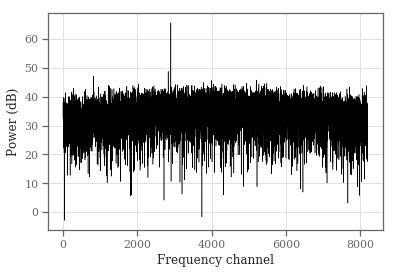

In [6]:
# Pre-processing: Show bandpass (Power against frequency)
time_sample = 471
channels = np.arange(0, 8192)
power = 10*np.log10(image_data[:, :, time_sample][0])

ax = sns.lineplot(x=channels, y=power, sort=False, lw=0.5, color='black')
ax.set(xlabel='Frequency channel', ylabel='Power (dB)')

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/bandpass.pdf')

(1, 8192)
1.9139573746753216 35.09656782343717
Noise: 35.097 dB, Old Threshold: 44.707 dB, New Thres: 42.752 dB


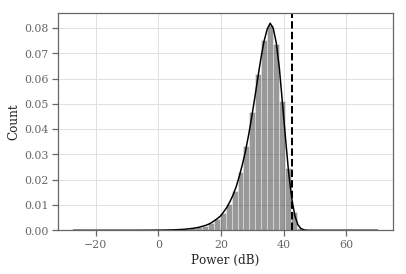

In [9]:
# Background noise filter: Show noise distribution (histogram) before and after filter is applied
def db(power):
    return 10*np.log10(power)

def threshold(data):
    # Apply background filter
    mean = np.mean(data, axis=2)
    std = np.std(data, axis=2)
    threshold = 2 * std + mean    
#     print(db(mean), db(std), db(threshold))
    return threshold

def rms(power_data):
    return np.sqrt(np.mean(np.power(power_data,2), axis=2))
    
time_samples = [400, 600]
channels = np.arange(0, 8192)
power = db(image_data[:, :, time_samples[0]:time_samples[1]][0])    

noise_dataset = db(image_data[:, :, 10:20])
noise = rms(noise_dataset)
db_thres = threshold(noise_dataset)
new_thres =  np.std(noise) * 4 + np.mean(noise)
print db_thres.shape
print np.std(noise),np.mean(noise)

print('Noise: {:0.3f} dB, Old Threshold: {:0.3f} dB, New Thres: {:0.3f} dB'.format(np.mean(noise), np.mean(db_thres), new_thres))

ax2 = sns.distplot(power.flatten(), color='black')
ax2.set(xlabel='Power (dB)', ylabel='Count')   
ax2.axvline(x=new_thres, ymin=0, ymax=1, linewidth=2,linestyle='dashed', color='black')

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/noise_distribution.pdf')

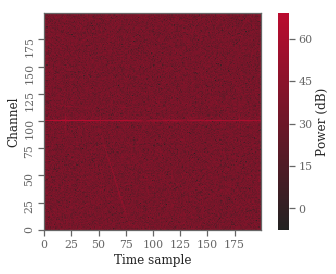

In [10]:
# Transmitter filter: show waterfall before background noise filter is applied
subset = power[2800:3000, :]
filter_mask = np.where(subset<new_thres, subset, 0)
ax3 = sns.heatmap(subset, cbar_kws={'label': 'Power (dB)'}, 
                  square=True, 
                  xticklabels=25, 
                  yticklabels=25,cmap=CMAP
                 )
ax3.invert_yaxis()
ax3.set(xlabel='Time sample', ylabel='Channel')   

for _, spine in ax3.spines.items():
    spine.set_visible(True)

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/before_filtering.pdf')

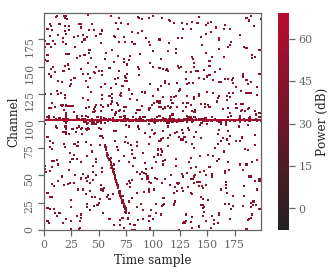

In [10]:
# Transmitter filter: show waterfall after background noise filter is applied
subset = power[2800:3000, :]
filter_mask = np.where(subset<new_thres, subset, 0)
ax4 = sns.heatmap(subset, cbar_kws={'label': 'Power (dB)'}, 
                  square=True, 
                  xticklabels=25, 
                  yticklabels=25,
                  mask=filter_mask, cmap=CMAP
                 )
ax4.invert_yaxis()
ax4.set(xlabel='Time sample', ylabel='Channel')   

for _, spine in ax4.spines.items():
    spine.set_visible(True)

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/before_tx_filter.pdf')

[100 101 102]
After applying the Tx Filter, 968 pixels remain out of 1281


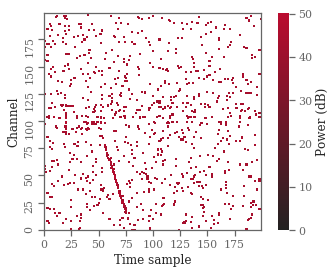

In [11]:
# Transmitter filter: show waterfall after transmitter filter is applied

def filter_tx(data):
    summed = np.sum(data, axis=1)
    peaks_snr_i = np.unique(np.where(summed > np.mean(summed) + np.std(summed) * 2.0))    
    print peaks_snr_i
    data[peaks_snr_i, :] = 0.0
#     data[peaks_snr_i] = data[peaks_snr_i] - np.mean(data[peaks_snr_i], axis=1, keepdims=True)
#     data[data <= 0.0] = 0.0
    
    return data

subset_without_background_noise = np.where(subset>new_thres, subset, 0)
subset_without_tx = filter_tx(subset_without_background_noise.copy())

print ('After applying the Tx Filter, {} pixels remain out of {}'.format(np.count_nonzero(subset_without_tx), np.count_nonzero(subset_without_background_noise)))

ax5 = sns.heatmap(subset_without_tx, cbar_kws={'label': 'Power (dB)'}, 
                  square=True, 
                  xticklabels=25, 
                  yticklabels=25, mask=subset_without_tx <= 0., cmap=CMAP)


ax5.invert_yaxis()
ax5.set(xlabel='Time sample', ylabel='Channel')   

for _, spine in ax5.spines.items():
    spine.set_visible(True)

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/after_tx_filter.pdf')


After applying the PN Filter, 273 pixels remain out of 968


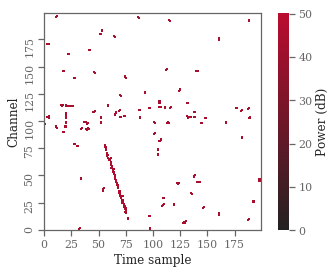

In [12]:
# Pepper-noise filter: show waterfall after pepper-noise filter is applied
from scipy.ndimage import binary_hit_or_miss
structure = np.zeros((3, 3))
structure[1, 1] = 1

subset2 = subset_without_tx.copy()
subset2[binary_hit_or_miss(subset2, structure1=structure)] = 0.
print ('After applying the PN Filter, {} pixels remain out of {}'.format(np.count_nonzero(subset2), np.count_nonzero(subset_without_tx)))

# sns.palplot(sns.diverging_palette(128, 240, n=10))
cmap = sns.diverging_palette(0, 256,as_cmap=True)
ax6 = sns.heatmap(subset2, cbar_kws={'label': 'Power (dB)'}, 
                  square=True, 
                  xticklabels=25, 
                  yticklabels=25, mask=subset2 <= 0., cmap=CMAP)



ax6.invert_yaxis()
ax6.set(xlabel='Time sample', ylabel='Channel')   

for _, spine in ax6.spines.items():
    spine.set_visible(True)

if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/after_pn_filter.pdf')

7, unique clusters were found
Noise is 147 pixels long
Cluster 1 is 72 pixels long
Cluster 2 is 10 pixels long
Cluster 3 is 9 pixels long
Cluster 4 is 9 pixels long
Cluster 5 is 9 pixels long
Cluster 6 is 6 pixels long
Cluster 7 is 11 pixels long


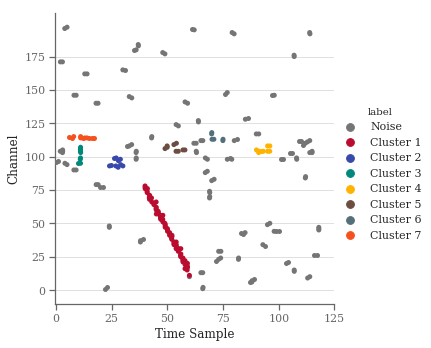

In [19]:
# Perform DBSCAN clustering algoritm
from itertools import cycle
from sklearn.cluster import DBSCAN
_eps = 5
_min_samples = 5
_algorithm = 'kd_tree'
db_scan = DBSCAN(eps=_eps, min_samples=_min_samples, algorithm=_algorithm, n_jobs=-1)

subset3 = subset2.copy()

ndx = np.where(subset3 > 0.)
X, snr = np.column_stack(ndx), subset3[ndx]

c_labels = db_scan.fit_predict(X)
labelled_data = np.append(X, np.expand_dims(c_labels, axis=1), axis=1)
unique_cluster_labels = np.unique(labelled_data[:, 2]).tolist()

print '{}, unique clusters were found'.format(len(unique_cluster_labels) -1)

df = pd.DataFrame({
    'channel': [], 'time':[], 'power': [], 'label': []
})

COLORS = cycle(['#5E35B1', UNI_RED, '#3949AB','#00897B', '#FFB300', '#6D4C41', '#546E7A', '#F4511E'])
noise_color = ['#757575']
color_map = {}
for label in unique_cluster_labels:
    label_mask = labelled_data[:, 2] == label
    channel_ndx = labelled_data[label_mask][:, 0]
    time_ndx = labelled_data[label_mask][:, 1]
    snr_data = snr[label_mask]
    
    text_label = 'Cluster {}'.format(label+1)
    color_map[text_label] = COLORS.next()
    if label == -1:
        text_label = 'Noise'
        color_map[text_label] = '#757575'
    
    df2 = pd.DataFrame({
        'channel': channel_ndx, 'time':time_ndx, 'power': snr_data, 'label': np.full(time_ndx.shape[0], text_label)
    })
    
    print ('{} is {} pixels long'.format(text_label,  len(df2)))

    df = df.append(df2)
    
    
COLORS = {
    'Cluster '
}
ax7 = sns.catplot(x="time", y="channel", hue='label', data=df, legend_out=True, jitter=True, palette=color_map,edgecolor="#666666" );
ax7.set(xticklabels=np.arange(0, 150, 25), xticks=np.arange(0, 150, 25))
ax7.set(yticklabels=np.arange(0, 200, 25), yticks=np.arange(0, 200, 25))
ax7.set(xlabel='Time Sample', ylabel='Channel')
# ax7.set(yticklabels=np.arange(0, 200, 25), yticks=np.arange(0, 200, 25))
ax7.set()



if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/dbscan_results.pdf')